In [68]:
#Imports

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [72]:
#paths

In [74]:
data_train_path = 'data/train'
data_val_path = 'data/validation'
data_test_path = 'data/test'
model_save_path = 'models/image_classify.keras'

In [76]:
img_width, img_height = 180, 180
batch_size = 32

In [78]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 3115 files belonging to 36 classes.


In [80]:
data_cat = data_train.class_names
print(f"Classes found ({len(data_cat)}): {data_cat}")

Classes found (36): ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [82]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    shuffle=False,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 351 files belonging to 36 classes.


In [84]:
data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    shuffle=False,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 359 files belonging to 36 classes.


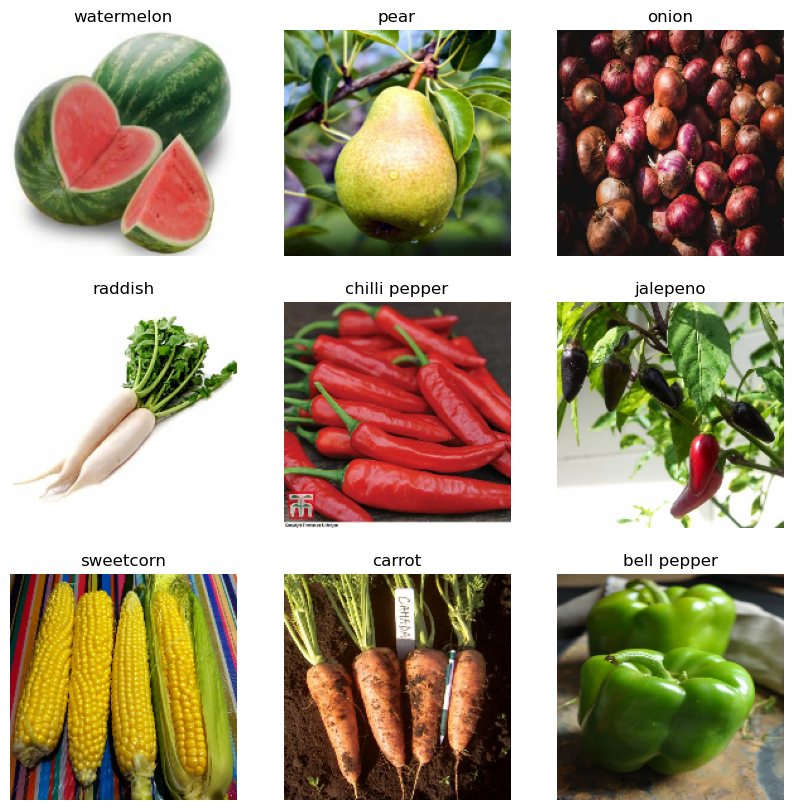

In [85]:
plt.figure(figsize=(10,10))
for images, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
plt.show()

In [88]:
# Prefetch for performance optimization

In [90]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = data_train.prefetch(buffer_size=AUTOTUNE)
val_ds = data_val.prefetch(buffer_size=AUTOTUNE)
test_ds = data_test.prefetch(buffer_size=AUTOTUNE)

In [92]:
num_classes = len(data_cat)

In [94]:
print(f"Number of classes: {num_classes}")

Number of classes: 36


In [96]:
#Data Augmentation

In [98]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [100]:
#Model: Transfer Learning with MobileNetV2 

In [102]:
img_height = 224
img_width = 224

base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [106]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [104]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
#Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')

In [ ]:
#Train the Model

In [ ]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)

In [19]:
from tensorflow.keras.models import Sequential

In [20]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128),
    layers.Dense(len(data_cat))
                  
])

In [26]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
epochs_size = 25
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 857ms/step - accuracy: 0.0668 - loss: 3.5462 - val_accuracy: 0.2934 - val_loss: 2.4054
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 66s 670ms/step - accuracy: 0.2751 - loss: 2.4784 - val_accuracy: 0.5869 - val_loss: 1.4720
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 709ms/step - accuracy: 0.4697 - loss: 1.8291 - val_accuracy: 0.7635 - val_loss: 0.9129
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 645ms/step - accuracy: 0.6383 - loss: 1.2393 - val_accuracy: 0.8746 - val_loss: 0.4810
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 90s 901ms/step - accuracy: 0.8026 - loss: 0.6560 - val_accuracy: 0.8974 - val_loss: 0.4289
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 812ms/step - accuracy: 0.8933 - loss: 0.4012 - val_accuracy: 0.9345 - val_loss: 0.3443
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 446ms/step - accuracy: 0.9319 - loss: 0.2948 - val_accuracy: 0.9573 - val_loss: 0.3169
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.9585 - loss: 0.2004 - val_accu

In [ ]:
epochs_range = range(epochs_size)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
image = 'Sample/Apple.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [ ]:
predict = model.predict(img_bat)

In [ ]:
score = tf.nn.softmax(predict)

In [ ]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(data_cat[np.argmax(score)],np.max(score)*100))

In [ ]:
model.save('Image_classify.keras')